# Elastic 3D beam structures

This tour explores the formulation of 3D beam-like elastic structures in FEniCS. One particularity of this tour is that the mesh topology is 1D (beams) but is embedded in a 3D ambient space. We will also show how to define a local frame containing the beam axis direction and two perpendicular directions for the definition of the cross-section geometrical properties. This tour is illustrated on a shell-like structure made of beams and is available in `.xdmf` format.

## Variational formulation: beam kinematics and consititutive equations

The variational formulation for 3D beams requires to distinguish between motion along the beam direction and along both perpendicular directions. These two directions often correspond to principal directions of inertia and distinguish between stong and weak bending directions. The user must therefore specify this local orientation frame throughout the whole structure. In this example, we will first compute the vector $t$ tangent to the beam direction, and two perpendicular directions $a_1$ and $a_2$. $a_1$ will always be perpendicular to $t$ and the vertical direction, while $a_2$ will be such that $(t, a_1, a_2)$ is a direct orthonormal frame.

 In the following, we will consider a Timoshenko beam model with St-Venant uniform torsion theory for the torsional part. The beam kinematics will then be described by a 3D displacement field $\boldsymbol{u}$ and an independent 3D rotation field $\boldsymbol{\theta}$, that is 6 degrees of freedom at each point. $(u_t,u_1,u_2)$ will respectively denote the displacement components in the section local frame $(t, a_1, a_2)$. Similarly, $\theta_1$ and $\theta_2$ will denote the section rotations about the two section axis whereas $\theta_t$ is the twist angle.

The beam strains are given by:

* the **normal strain**: $\delta = \dfrac{d u_t}{ds}$
* the **bending curvatures**: $\chi_1 = \dfrac{d\theta_1}{ds}$ and $\chi_2 = \dfrac{d\theta_2}{ds}$
* the **shear strains**: $\gamma_1 = \dfrac{du_1}{ds}-\theta_2$ and
    $\gamma_2 = \dfrac{du_2}{ds}+\theta_1$. 
* the **torsional strain**: $\omega = \dfrac{d\theta_t}{ds}$. 

where $\dfrac{dv}{ds} = \nabla v \cdot t$ is the tangential gradient. Associated with these generalized strains are the corresponding generalized stresses:

* the **normal force** $N$
* the **bending moments** $M_1$ and $M_2$
* the **shear forces** $Q_1$ and $Q_2$
* the **torsional moment** $M_T$

The beam constitutive equations (assuming no normal force/bending moment coupling and that $a_1$ and $a_2$ are the principle axis of inertia) read as:
$$\begin{Bmatrix}
N \\ Q_1 \\ Q_2 \\ M_T \\ M_1 \\ M_2 
\end{Bmatrix} = \begin{bmatrix}
ES & 0 & 0 & 0 & 0 & 0\\
0 & GS_1 & 0 & 0 & 0 & 0\\
0 & 0 & GS_2 & 0 & 0 & 0\\
0 & 0 & 0 & GJ & 0 & 0\\
0 & 0 & 0 & 0 & EI_1 & 0\\
0 & 0 & 0 & 0 & 0 & EI_2
\end{bmatrix}\begin{Bmatrix}
\delta \\ \gamma_1 \\ \gamma_2 \\ \omega \\ \chi_1 \\ \chi_2 
\end{Bmatrix}$$

where $S$ is the cross-section area, $E$ the material Young modulus and $G$ the shear modulus, $I_1=\int_S x_2^2 dS$ (resp. $I_2=\int_S x_1^2 dS$) are the bending second moment of inertia about axis $a_1$ (resp. $a_2$), $J$ is the torsion inertia, $S_1$ (resp. $S_2$) is the shear area in direction $a_1$ (resp. $a_2$).

The 3D beam variational formulation finally reads as: Find $(\boldsymbol{u},\boldsymbol{\theta})\in V$ such that:
$$\int_S (N\widehat{\delta}+Q_1\widehat{\gamma}_1+Q_2\widehat{\gamma}_2+M_T\widehat{\omega}+M_1\widehat{\chi}_1+M_2\widehat{\chi}_2)dS = \int \boldsymbol{f}\cdot\widehat{\boldsymbol{u}}dS \quad \forall (\widehat{\boldsymbol{u}},\widehat{\boldsymbol{\theta}})\in V$$

where we considered only a distributed loading $\boldsymbol{f}$ and where $\widehat{\delta},\ldots,\widehat{\chi}_2$ are the generalized strains associated with test functions $(\widehat{\boldsymbol{u}},\widehat{\boldsymbol{\theta}})$.

## FEniCS implementation

After first loading the shell mesh file in `.xdmf` format, we will use the UFL `Jacobian` function which computes the transformation Jacobian between a reference element (interval here) and the current element. For the present case, the Jacobian is of shape (3,1). Transforming it into a vector of unit length will give us the local tangent vector $t$.

In [20]:
from dolfin import *
from ufl import Jacobian, diag
from plotting import plot

mesh = Mesh()
filename = "shell.xdmf"
f = XDMFFile(filename)
f.read(mesh)

def tangent(mesh):
    t = Jacobian(mesh)
    return as_vector([t[0,0], t[1, 0], t[2, 0]])/sqrt(inner(t,t))

t = tangent(mesh)

We now compute the section local axis. As mentioned earlier, $a_1$ will be perpendicular to $t$ and the vertical direction $e_z=(0,0,1)$. After normalization, $a_2$ is built by taking the cross product between $t$ and $a_1$, $a_2$ will therefore belong to the plane made by $t$ and the vertical direction.

In [21]:
ez = as_vector([0, 0, 1])
a1 = cross(t, ez)
a1 /= sqrt(dot(a1, a1))
a2 = cross(t, a1)
a2 /= sqrt(dot(a2, a2))

We now define the material and geometrical constants which will be used in the constitutive relation. We consider the case of a rectangular cross-section of width $b$ and height $h$ in directions $a_1$ and $a_2$. The bending inertia will therefore be $I_1 = bh^3/12$ and $I_2=hb^3/12$. The torsional inertia is $J=\beta hb^3$ with $\beta\approx 0.26$ for $h=3b$. Finally, the shear areas are approximated by $S_1=S_2=\kappa S$ with $\kappa=5/6$.

In [22]:
thick = Constant(0.3)
width = thick/3
E = Constant(70e3)
nu = Constant(0.3)
G = E/2/(1+nu)
rho = Constant(2.7e-3)
g = Constant(9.81)

S = thick*width
ES = E*S
EI1 = E*width*thick**3/12
EI2 = E*width**3*thick/12
GJ = G*0.26*thick*width**3
kappa = Constant(5./6.)
GS1 = kappa*G*S
GS2 = kappa*G*S

We now consider a mixed $\mathbb{P}_1/\mathbb{P}_1$-Lagrange interpolation for the displacement and rotation fields. The variational form is built using a function `generalized_strains` giving the vector of six generalized strains as well as a function `generalized_stresses` which computes the dot product of the strains with the above-mentioned constitutive matrix (diagonal here). Note that since the 1D beams are embedded in an ambient 3D space, the gradient operator has shape (3,), we therefore define a tangential gradient operator `tgrad` by taking the dot product with the local tangent vector $t$.

Finally, similarly to Reissner-Mindlin plates, shear-locking issues might arise in the thin beam limit. To avoid this, reduced integration is performed on the shear part $Q_1\widehat{\gamma}_1+Q_2\widehat{\gamma}_2$ of the variational form using a one-point rule.

In [23]:
Ue = VectorElement("CG", mesh.ufl_cell(), 1, dim=3)
W = FunctionSpace(mesh, Ue*Ue)

u_ = TestFunction(W)
du = TrialFunction(W)
(w_, theta_) = split(u_)
(dw, dtheta) = split(du)

def tgrad(u):
    return dot(grad(u), t)
def generalized_strains(u):
    (w, theta) = split(u)
    return as_vector([tgrad(dot(w, t)),
                      tgrad(dot(w, a1))-dot(theta, a2),
                      tgrad(dot(w, a2))+dot(theta, a1),
                      tgrad(dot(theta, t)),
                      tgrad(dot(theta, a1)),
                      tgrad(dot(theta, a2))])
def generalized_stresses(u):
    return dot(diag(as_vector([ES, GS1, GS2, GJ, EI1, EI2])), generalized_strains(u))

Sig = generalized_stresses(du)
Eps =  generalized_strains(u_)

dx_shear = dx(scheme="default",metadata={"quadrature_scheme":"default", "quadrature_degree": 1})
k_form = sum([Sig[i]*Eps[i]*dx for i in [0, 3, 4, 5]]) + (Sig[1]*Eps[1]+Sig[2]*Eps[2])*dx_shear
l_form = Constant(-rho*S*g)*w_[2]*dx

Clamped boundary conditions are considered at the bottom $z=0$ level and the linear problem is finally solved.

AttributeError: Matplotlib plotting backend only supports 2D mesh for scalar functions.

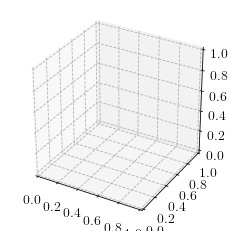

In [24]:
def bottom(x, on_boundary):
    return near(x[2], 0.)
bc = DirichletBC(W, Constant((0, 0, 0, 0, 0, 0)), bottom)

u = Function(W)
solve(k_form == l_form, u, bc)
plot(u[0])

Matplotlib functions cannot plot functions defined on a 1D mesh embedded in a 3D space so that we output the solution fields to XDMF format for vizualisation with Paraview for instance. We also export the bending moments by projecting them on a suitable function space.

In [ ]:
ffile = XDMFFile("shell-results.xdmf")
ffile.parameters["functions_share_mesh"] = True
v = u.sub(0, True)
v.rename("Displacement", v.name())
ffile.write(v, 0.)
theta = u.sub(1, True)
theta.rename("Rotation", theta.name())
ffile.write(theta, 0.)

V1 = VectorFunctionSpace(mesh, "CG", 1, dim=2)
M = Function(V1, name="Bending moments (M1,M2)")
Sig = generalized_stresses(u)
M.assign(project(as_vector([Sig[4], Sig[5]]), V1))
ffile.write(M, 0)

ffile.close()

Bending moment amplitude over the structure would look like this: